### ML Setup

In [ ]:
import sys
import typing
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
# sijio
rng_seed = 90
torch.manual_seed(rng_seed)

if torch.cuda.is_available():
    device = torch.device("cuda:0")

ModuleNotFoundError: No module named 'torch'

Extracting EDF parameters from C:\Users\mbaza\PycharmProjects\demysml-ml1\S108R01.edf...
Setting channel info structure...
Creating raw.info structure...
<RawEDF | S108R01.edf, 64 x 9760 (61.0 s), ~52 KiB, data not loaded>

Sampling rate: 160.0
Channels: ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']
<Annotations | 1 segment: T0 (1)>
Number of channels: 64
Duration (sec): 61.0

First 10 samples:
[[-3.40e-05  1.00e-05  6.10e-05  1.80e-05 -8.00e-06  2.60e-05  4.00e-06
   4.60e-05  1.90e-05  1.30e-05]
 [-1.10e-05  2.30e-05  5.60e-0

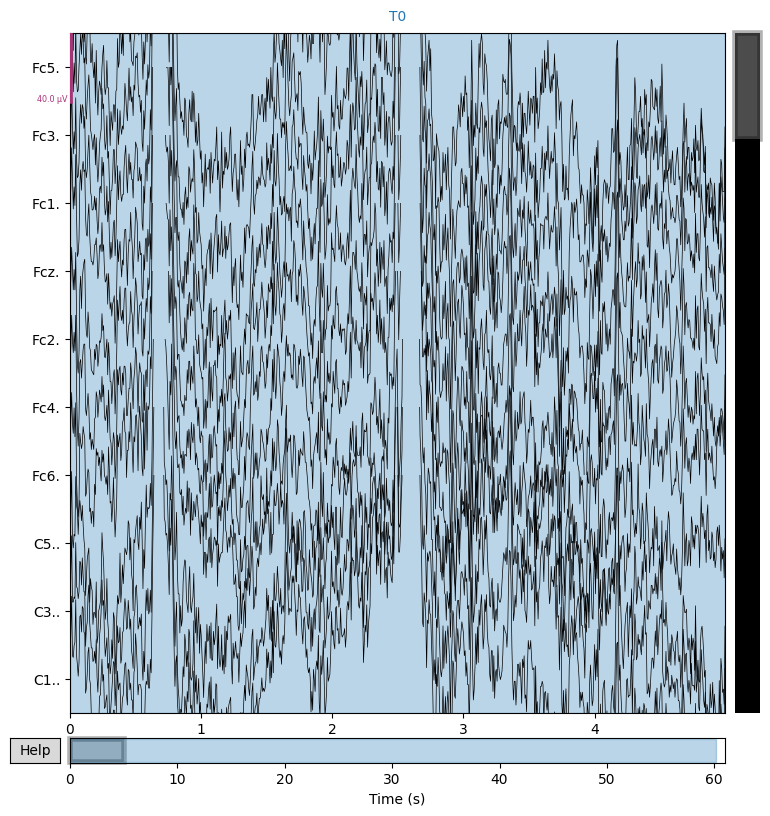

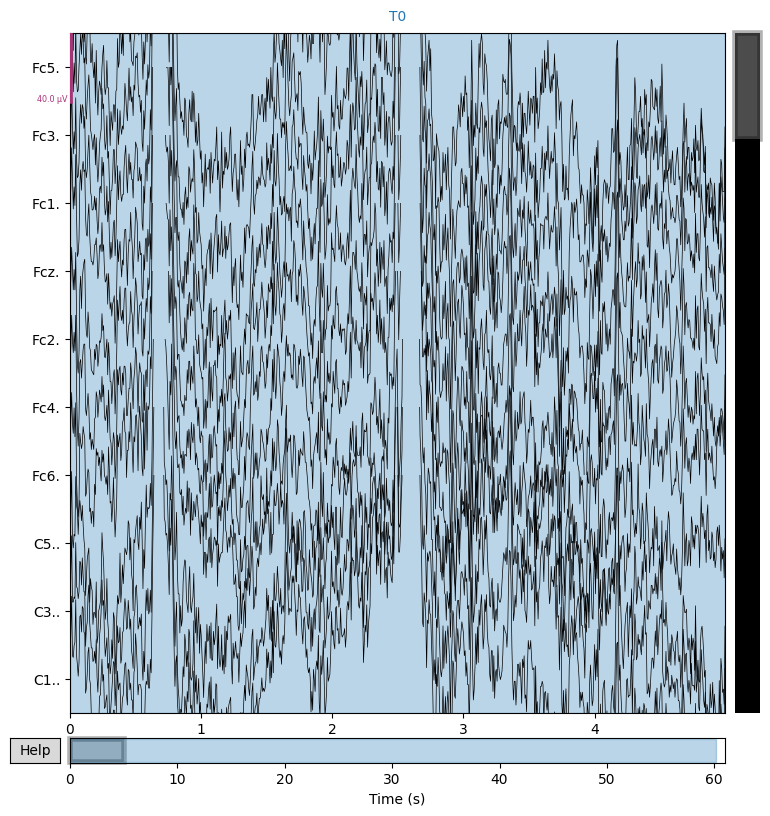

In [ ]:
from pathlib import Path
import mne

edf_path = Path.cwd() / "S108R01.edf"

raw = mne.io.read_raw_edf(edf_path, preload=False)

print(raw)

# ---- 2. Print metadata ----
print("\nSampling rate:", raw.info["sfreq"])
print("Channels:", raw.info["ch_names"])
print(raw.annotations)
print("Number of channels:", raw.info["nchan"])
print("Duration (sec):", raw.n_times / raw.info["sfreq"])

# ---- 3. Print small slice of signal values ----
data, times = raw[:, :10]   # first 10 samples
print("\nFirst 10 samples:")
print(data)

# ---- 4. Plot signals ----
raw.plot(n_channels=10, duration=5)

In [ ]:
from typing import List
import os
from torch.utils.data import Dataset, DataLoader

train_subjects = [i for i in range(1, 100)] # 1-99
test_subjects = [i for i in range(100, 110)] # 100-109


eegmmidb_path = Path.cwd() / "eeg-motor-movementimagery-dataset-1.0.0" / "files"

class EEGMMIDBDataset(Dataset):
    def __init__(self, path: Path, subjects: List[int]):
        self.path = path
        self.files = []
        for subject in subjects:
            sub_folder = self.path / f"S{subject:03d}"

            for fname in os.listdir(sub_folder):
                if fname.endswith(".edf"):
                    self.files.append(sub_folder / fname)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        R = int(path.stem.split("R")[1])
        raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
        data = raw.get_data().astype("float32")
        return torch.tensor(data), R

def get_num_workers():
    suggested_workers = 0
    if hasattr(os, 'sched_getaffinity'):
        try:
            suggested_workers = len(os.sched_getaffinity(0))
        except Exception:
            pass
    if suggested_workers == 0:
        cpu_count = os.cpu_count()
        if cpu_count is not None:
            suggested_workers = cpu_count
    num_workers = min(8, suggested_workers)
    return num_workers

num_workers = get_num_workers()

loader_train = DataLoader(
    EEGMMIDBDataset(eegmmidb_path, train_subjects),
    batch_size=32,
    shuffle=True,
    num_workers=num_workers
)
loader_test = DataLoader(
    EEGMMIDBDataset(eegmmidb_path, test_subjects),
    batch_size=32,
    shuffle=True,
    num_workers=num_workers
)


In [ ]:
import torch
import torch.nn as nn


class EEGNet(nn.Module):

    def __init__(self, nb_classes: int, in_channels: int):
        super().__init__()

        F1 = 8
        D = 2
        F2 = F1 * D
        fs = 160 # Sampling frequency
        kernel_length = fs // 2

        self.block1 = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernel_length), padding=(0, kernel_length // 2), bias=False),
            nn.BatchNorm2d(F1),

            nn.Conv2d(F1, F1 * D, (in_channels, 1), groups=F1, bias=False),
            nn.BatchNorm2d(F1 * D),

            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.5)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(F1 * D, F1 * D, (1, 16), padding=(0, 8), groups=F1 * D, bias=False),
            nn.Conv2d(F1 * D, F2, 1, bias=False),

            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.5)
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Linear(F2, nb_classes)

    def forward(self, x):
        x = x.unsqueeze(1)

        x = self.block1(x)
        x = self.block2(x)

        x = self.adaptive_pool(x)

        x = x.flatten(start_dim=1)
        return self.classifier(x)


In [ ]:
model = EEGNet(nb_classes=15, in_channels=64)

x = torch.randn(16, 64, 160)
y = model(x)

print(y.shape)

torch.Size([16, 15])


In [ ]:
# Training
dtype = torch.float32

def train_model(model, train_loader, optimizer, epochs=10):
    model = model.to(device)
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()
            x = x.to(device, dtype=dtype)
            y = y.to(device, dtype=dtype)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % 100 == 0:
                print("TODO")
